In [1]:
import csv, os, zipfile, datetime, re
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm

### Problem

In the NFL, gaining even a small edge in anticipating an opponent's next move can dramatically impact game outcomes. One of the most valuable predictive insights is whether the offense will run or pass on a given play. My objective is to build a model that predicts this play type in real time. By doing so, the defensive coaching staff can make more informed decisions about substitutions, alignments, and tactical assignments. This predictive advantage could improve overall defensive efficiency and responsiveness during critical moments.


In [ ]:
#


#Data Source: https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016
plays = pd.read_csv("files/input/NFL Play by Play 2009-2018 (v5).csv")



/var/folders/0p/p8g1hvy94_q9bd228nd5dfyr0000gn/T/ipykernel_37699/2308403348.py:2: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  plays = pd.read_csv("files/input/NFL Play by Play 2009-2018 (v5).csv")


In [3]:
#CONSTANTS

KEEP_COLUMNS = {
    "play_id": "Int64",
    "game_id": "string",
    "home_team": "string",
    "away_team": "string",
    "posteam": "string",
    "posteam_type": "string",
    "side_of_field": "string",
    "yardline_100": "Int64",
    "game_date": datetime,
    "half_seconds_remaining": "Int64",
    "game_half": "string",
    "drive": "Int64",
    "down": "Int64", 
    "goal_to_go": "Int64", 
    "ydsnet": "Int64",
    "desc": "string",
    "ydstogo": "Int64", 
    "play_type": "string",
    "yards_gained": "Int64",
    "shotgun": 	"Int64", 
    "no_huddle": 	"Int64",
    "qb_dropback": 	"Int64",
    "qb_scramble": "Int64",
    "pass_length": "Int64", 
    "pass_location": "string",
    "run_location": "string",
    "run_gap": "string", 
    "posteam_timeouts_remaining": "Int64", 
    "defteam_timeouts_remaining": "Int64", 
    "posteam_score": "Int64", 
    "defteam_score": "Int64",
    "score_differential": "Int64",

}

In [4]:
#Some data subsets for further explorations

plays.sample(1000).to_csv("files/output/full_preview.csv", index=False)
#print("\n".join(f"{i}. {c}" for i,c in enumerate(plays.columns)))
plays[KEEP_COLUMNS.keys()].sample(1000).to_csv("files/output/filtered_preview.csv", index=False)
plays[plays["game_id"] == 2009091000].to_csv("files/output/one_game_preview.csv", index=False)
print(len(plays))
plays["play_id"] = range(1, len(plays) + 1)
plays["yards_gained"] = plays["yards_gained"].fillna(0)



449371


### Exploratory Data Analysis (EDA)

During EDA, I reviewed the available dataset and removed any previously performed analysis to ensure a clean slate. I converted string-based categorical labels into integer representations for model compatibility. I also calculated cumulative statistics to uncover trends and patterns across drives and games. Null values were filled with appropriate defaults or estimates, and irrelevant or incomplete plays were removed to improve data quality. This preprocessing step ensured that the remaining data was both consistent and meaningful for modeling.


In [5]:
#Cleanup

#REMOVE UNNECESSARY COLUMNS
plays = plays[KEEP_COLUMNS.keys()]
for col,dtype in KEEP_COLUMNS.items():
    if dtype is datetime:
        plays[col] = pd.to_datetime(plays[col])
    else:
        plays[col] = plays[col].astype(dtype, errors="ignore")
        
plays["play_type"] = plays["play_type"].fillna("no_play")
plays["qb_dropback"] = plays["qb_dropback"].fillna(0)

In [6]:


#GET THE SEASON SO IT CAN BE USED FOR AGGREGATIONS
def determine_season(game_date):
    year = game_date.year
    if game_date.month < 8:
        return str(year - 1)
    return year
if "season" not in plays.columns:
    game_seasons = dict(( play[0], determine_season(play[1])) for play in plays[["game_id", "game_date"]].drop_duplicates().values.tolist())
    plays["season"] = plays["game_id"].apply(lambda x: game_seasons[x])




#GET THE TYPES OF PLAYS. THES WILL BE THE RESPONSE/DEPENDENT VARIABLES
plays[["pass_length", "pass_location", "run_location", "play_type"]] = plays[["pass_length", "pass_location", "run_location", "play_type"]].fillna("")
def determine_play_types(row):
    play_type_simple,play_type_adv = "",""
    if row["play_type"] == "no_play":
        return [play_type_simple, play_type_adv]   

    if row["qb_dropback"]:
        play_type_simple = "pass"
        if row["qb_scramble"]:
            play_type_adv = "scramble"
    elif row["play_type"] == "run":
        play_type_simple = "run"

    if row["run_location"]:
        play_type_adv = "run_" + row["run_location"]
    if row["pass_length"] and row["pass_location"]:
        play_type_adv = "pass_" + row["pass_length"] + "_" + row["pass_location"]
    if row["qb_scramble"]:
        play_type_adv = "pass_scramble"
    elif row["qb_dropback"] and not row["pass_length"]:
        play_type_adv = "pass_failure"
    return [play_type_simple, play_type_adv]

full_play_types = plays.apply(lambda row: determine_play_types(row), axis=1)
 
plays[["play_type_simple", "play_type_adv"]] = pd.DataFrame(full_play_types.to_list(), index=plays.index)


#Can Drop Irrelevant Plays Now
plays = plays[(plays["play_type_simple"].isin(["run", "pass"])) & (~plays["down"].isna())]


#Convert Home Team Possessions
plays["is_home_team"] = plays["posteam_type"].apply(lambda x: 1 if x=="home" else 0)

#Convert Half to Number
plays["half"] = plays["game_half"].apply(lambda x: {"Half1": 1, "Half2": 2, "Overtime": 3}[x])

#Convert Run Plays
plays["was_run_play"] = plays["play_type_simple"].apply(lambda x: 1 if x=="run" else 0)





In [7]:

#Aggregate previous team play selections and 
plays["season_cumul_run"] = (
    plays["play_type_simple"].eq("run")
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_run_yds"] = (
    plays["yards_gained"]
    .where(plays["play_type_simple"] == "run", 0)
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_pass"] = (
    plays["play_type_simple"].eq("pass")
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)

plays["season_cumul_pass_yds"] = (
    plays["yards_gained"]
    .where(plays["play_type_simple"] == "pass", 0)
    .groupby([plays["season"], plays["posteam"]])
    .cumsum()
    .shift(1)
    .fillna(0)
)
plays["season_cumul_run_avg"] = np.where(
    plays["season_cumul_run"] == 0,
    0,
    plays["season_cumul_run_yds"] / plays["season_cumul_run"]
)

plays["season_cumul_pass_avg"] = np.where(
    plays["season_cumul_pass"] == 0,
    0,
    plays["season_cumul_pass_yds"] / plays["season_cumul_pass"]
)

plays["season_run_play_percentage"] = np.where(
    (plays["season_cumul_run"] + plays["season_cumul_pass"]) == 0,
    0,
    plays["season_cumul_run"] / (plays["season_cumul_run"] + plays["season_cumul_pass"])
)



#Every start of season, these can be set to 0
cols = ["season_cumul_pass_avg", "season_cumul_run_avg", "season_cumul_pass_yds", "season_cumul_run_yds", "season_run_play_percentage"]
plays[cols] = plays[cols].fillna(0)

#When penalty occurs on last play of half, they redo without clock so they are null values
plays["half_seconds_remaining"] = plays["half_seconds_remaining"].fillna(0)


plays.to_csv("files/input/cleaned_plays.csv", index=False)




In [8]:
plays = pd.read_csv("files/input/cleaned_plays.csv")


AUC Is  0.780671350029289


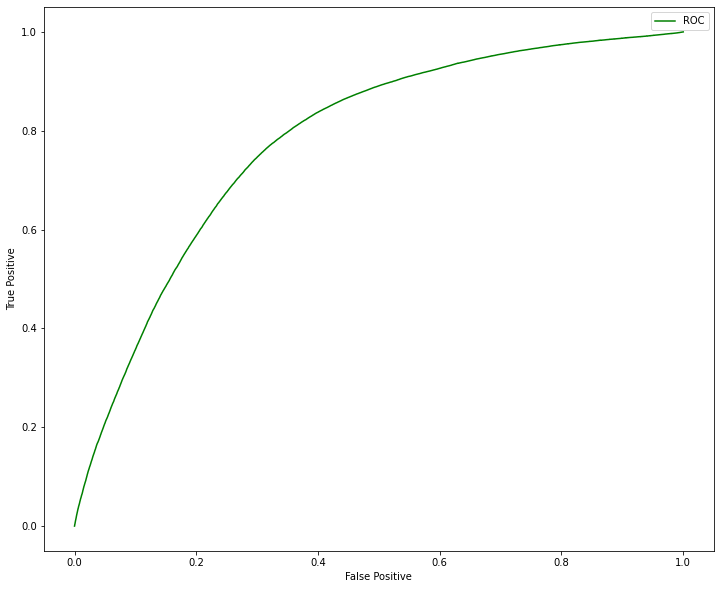

In [9]:

INITIAL_PREDICTOR_COLUMNS = ["season_cumul_run_avg", "season_cumul_pass_avg", "season_run_play_percentage", "is_home_team", "yardline_100", "half_seconds_remaining", "drive", "half", "down", "ydstogo", "shotgun", "score_differential"]


#SET UP TRAINING SPLIT 
x = plays[INITIAL_PREDICTOR_COLUMNS]
y = plays["was_run_play"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.8, random_state=22)

LogReg = LogisticRegression(solver="liblinear").fit(x_train, y_train.ravel())

yhat = LogReg.predict_proba(x_test)
yhat_prob = yhat[:,1]
false_positive,true_positive, trash = roc_curve(y_test, yhat_prob)

plt.figure(figsize=(12,10))
plt.plot(false_positive, true_positive, color="green", label="ROC")

plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend()
print("AUC Is ", roc_auc_score(y_test, yhat_prob))
plt.show()



In [10]:
#Maybe Remove Bad Predictors?
logit = sm.Logit(y_train, sm.add_constant(x_train)).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.548144
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           was_run_play   No. Observations:                63738
Model:                          Logit   Df Residuals:                    63725
Method:                           MLE   Df Model:                           12
Date:                Sat, 05 Apr 2025   Pseudo R-squ.:                  0.1834
Time:                        11:31:52   Log-Likelihood:                -34938.
converged:                       True   LL-Null:                       -42786.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.1359      0.095     22.569      0.000      

AUC Is  0.7804823288911941


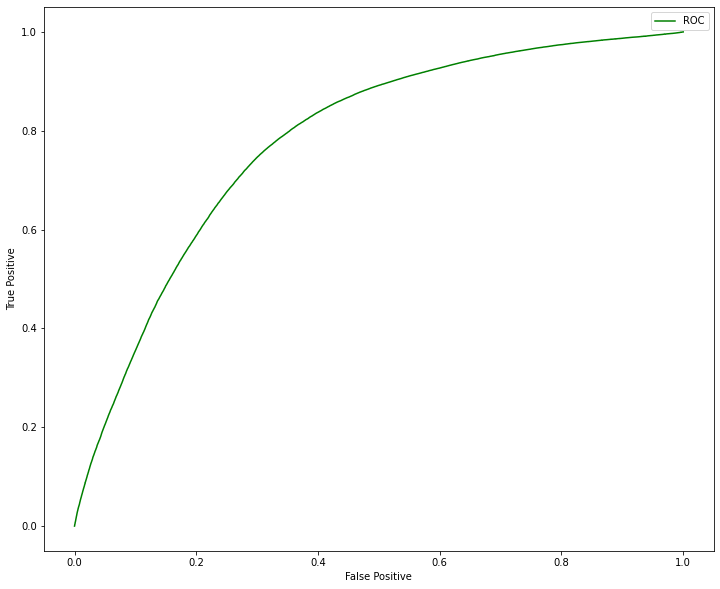

In [11]:
new_predictors = list(set(INITIAL_PREDICTOR_COLUMNS) - {"season_cumul_run_avg", "drive", "half" })

x = plays[new_predictors]
y = plays["was_run_play"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.8, random_state=22)

LogReg = LogisticRegression(solver="liblinear").fit(x_train, y_train.ravel())

yhat = LogReg.predict_proba(x_test)
yhat_prob = yhat[:,1]
false_positive,true_positive, trash = roc_curve(y_test, yhat_prob)

plt.figure(figsize=(12,10))
plt.plot(false_positive, true_positive, color="green", label="ROC")

plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend()
print("AUC Is ", roc_auc_score(y_test, yhat_prob))
plt.show()

In [12]:
seasons = plays["season"].unique()
season_AUCs = {}

for season in seasons:
    x = plays[plays["season"] == season][INITIAL_PREDICTOR_COLUMNS]
    y = plays[plays["season"] == season]["was_run_play"]
    x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.8, random_state=22)

    LogReg = LogisticRegression(solver="liblinear").fit(x_train, y_train.ravel())

    yhat = LogReg.predict_proba(x_test)
    yhat_prob = yhat[:,1]
    season_AUCs[season] = roc_auc_score(y_test, yhat_prob)
    
    
for k,v in dict(sorted(season_AUCs.items(), key=lambda item: item[1], reverse=True)).items():
    print(f"{k}: {round(v, 2)}")

2017: 0.79
2015: 0.79
2012: 0.79
2014: 0.78
2010: 0.78
2016: 0.78
2018: 0.78
2013: 0.78
2011: 0.78
2009: 0.77


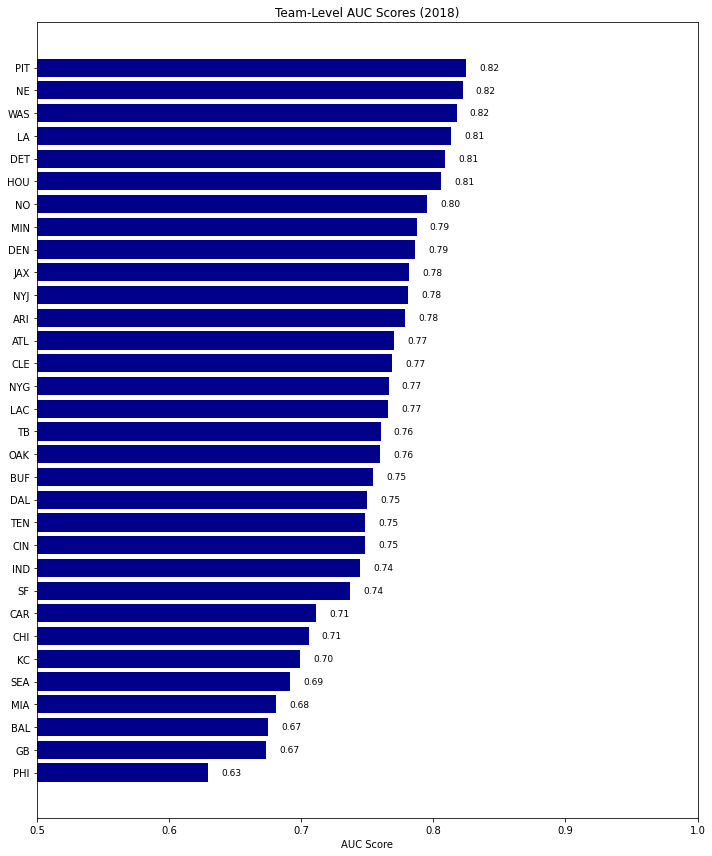

In [13]:
plays_2018 = plays[plays["season"] == 2018]

teams = plays_2018["posteam"].unique()
team_AUCs = {}

for team in teams:
    x = plays_2018[plays_2018["posteam"] == team][INITIAL_PREDICTOR_COLUMNS]
    y = plays_2018[plays_2018["posteam"] == team]["was_run_play"]
    x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.8, random_state=22)

    LogReg = LogisticRegression(solver="liblinear").fit(x_train, y_train.ravel())

    yhat = LogReg.predict_proba(x_test)
    yhat_prob = yhat[:,1]
    team_AUCs[team] = roc_auc_score(y_test, yhat_prob)
    
# Plot
sorted_aucs = dict(sorted(team_AUCs.items(), key=lambda item: item[1], reverse=True))
teams = list(sorted_aucs.keys())
aucs = list(sorted_aucs.values())

# Plot horizontal bars
plt.figure(figsize=(10, 12))
bars = plt.barh(teams, aucs, color="darkblue")
plt.xlabel("AUC Score")
plt.title("Team-Level AUC Scores (2018)")
plt.xlim(0.5, 1.0)
plt.gca().invert_yaxis()  # Highest AUC at top

# Annotate each bar with its AUC value
for bar, value in zip(bars, aucs):
    plt.text(value + 0.01, bar.get_y() + bar.get_height() / 2,
             f"{value:.2f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

    


### Conclusions

- We can make reasonably accurate run vs pass predictions using Logistic Regression.  
- The model shows relatively consistent predictive performance across different seasons.  
- Prediction accuracy varies by team — it performs noticeably better for some teams and worse for others.
